In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

In [53]:
""" Data """

sp500 = yf.Ticker("^GSPC").history(period="10y")
px_sp_s = sp500['Close']
px_sp_s.index = px_sp_s.index.date

In [52]:
jpy = yf.Ticker("JPY=X").history(period="10y")
px_jpy_s = jpy['Close']
px_jpy_s.index = px_jpy_s.index.date

In [117]:
# Normally we pull data using some pd.read_csv(".data1.csv") etc...

# Task 1

**Problem:** What is the sharp ratio of buy-and-hold strategy for SP500 for the last 10Y?

<AxesSubplot: >

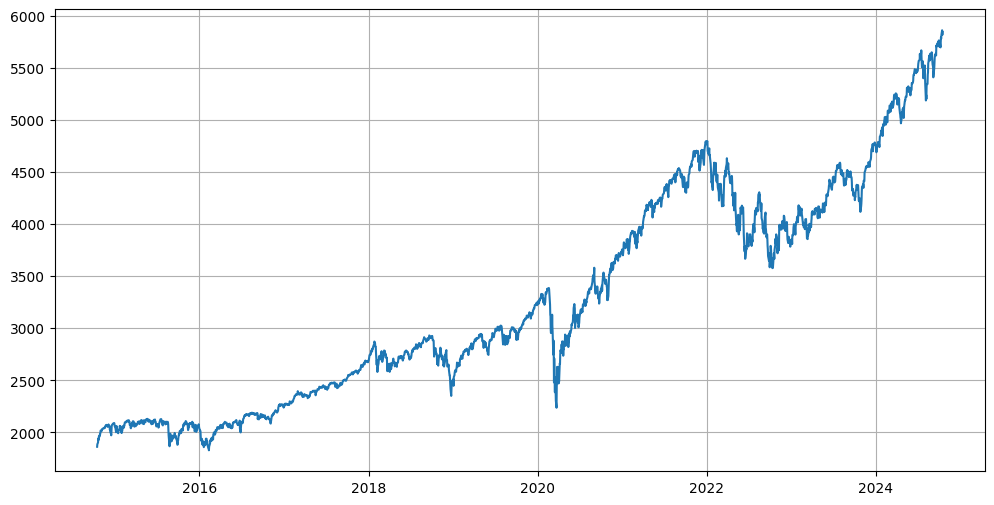

In [47]:
px_sp_s.plot(figsize=(12,6), grid=True)

<AxesSubplot: >

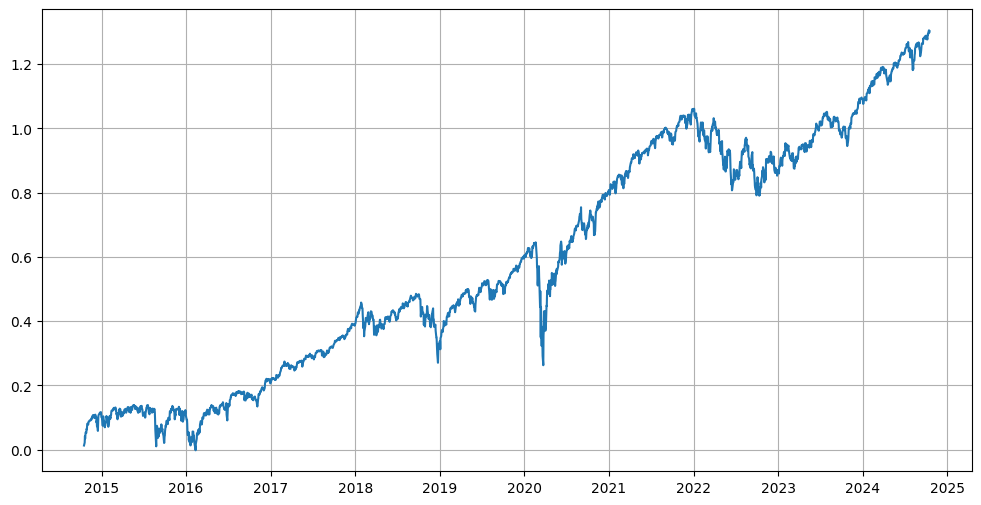

In [48]:
# Converting prices to daily returns
ret_s = px_sp_s.pct_change()
ret_s.cumsum().plot(figsize=(12,6), grid=True)

In [36]:
# Calculating average daily return
daily_ret = ret_s.mean()

In [35]:
# Calculating daily STD
daily_std = ret_s.std()
daily_std

0.011226050390846495

In [37]:
# Daily SR (not meaningful before annualizing)
daily_sr = daily_ret/daily_std
daily_sr

0.046130453769770714

In [42]:
# Annual SR (returns grow linearly with time, standard deviation with square root of time)
trading_day_per_year = 252
annual_sharp_ratio = (daily_ret * trading_day_per_year) / (daily_std * np.sqrt(trading_day_per_year))
annual_sharp_ratio

0.7322982512482521

# Task 2

**Problem:** Please build a strategy to trade a momentum signal for USDJPY.

<AxesSubplot: >

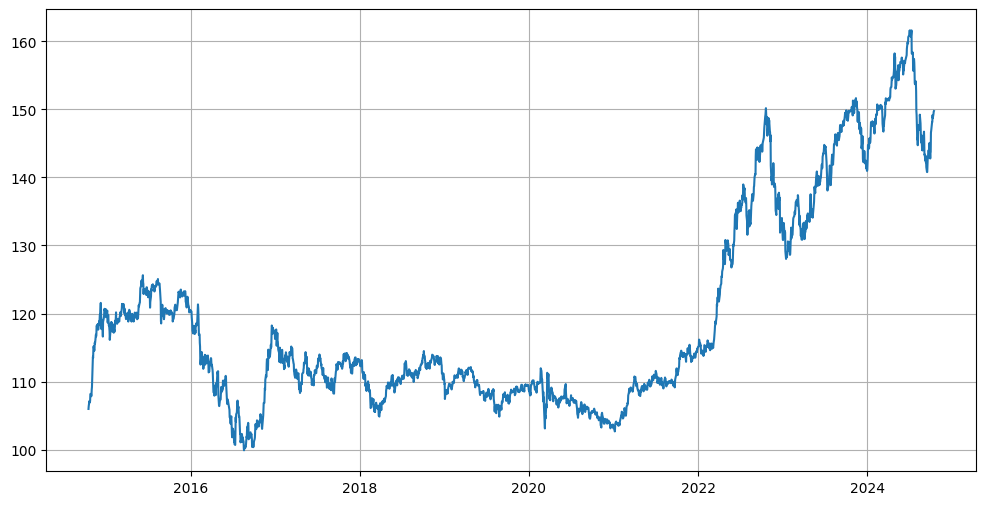

In [55]:
px_jpy_s.plot(figsize=(12,6), grid=True)

In [89]:
""" Momentum indicator: sum of returns of last 63 days > 0 -> buy, < 0 -> sell """
window = 63

ret_jpy_s = px_jpy_s.pct_change()
momentum = ret_jpy_s.rolling(window).sum()

<AxesSubplot: >

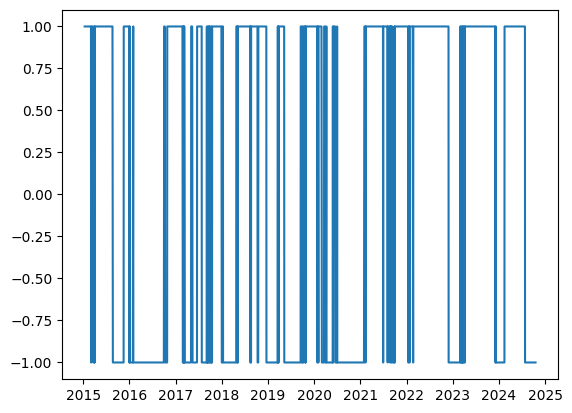

In [91]:
signal_mom = momentum.dropna().apply(lambda x: 1 if x > 0 else -1)
signal_mom.plot()

<AxesSubplot: title={'center': '63D Momentum USDJPY'}>

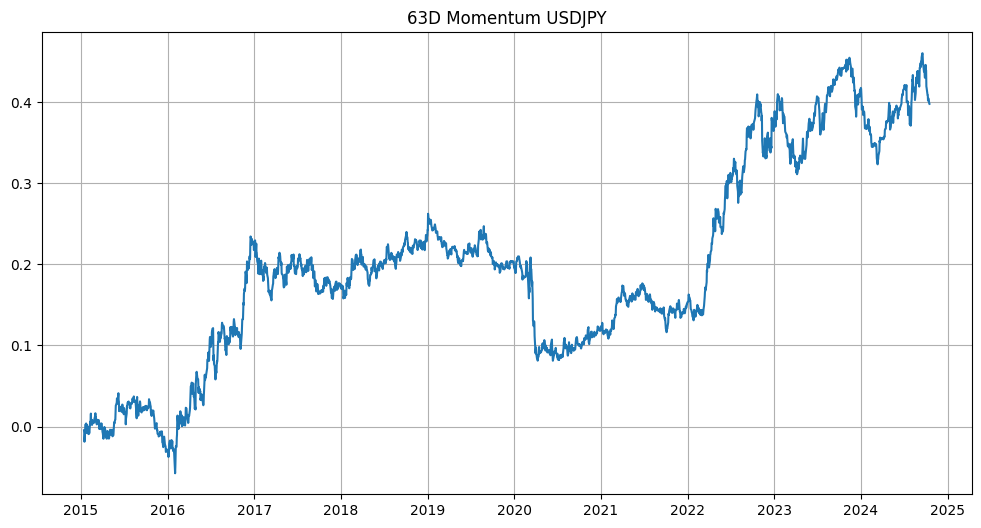

In [92]:
jpy_mom_returns = (ret_jpy_s * signal_mom.shift(1)).dropna()
jpy_mom_returns.cumsum().plot(figsize=(12,6), grid=True, title="63D Momentum USDJPY")

# Task 3

**Problem:** Now make it a mean-reversion strategy

*Piotr comment:* This is actually as easy as replacing 1 with -1. If symbol was going up recently we assume it should start going down. 

<AxesSubplot: >

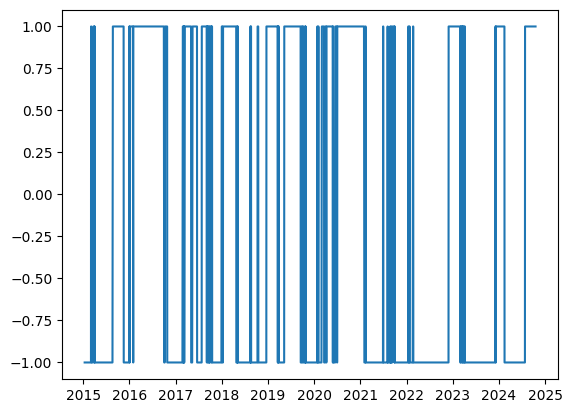

In [85]:
signal_mr = momentum.dropna().apply(lambda x: -1 if x > 0 else 1)
signal_mr.plot()

<AxesSubplot: title={'center': '63D Mean Rev USDJPY'}>

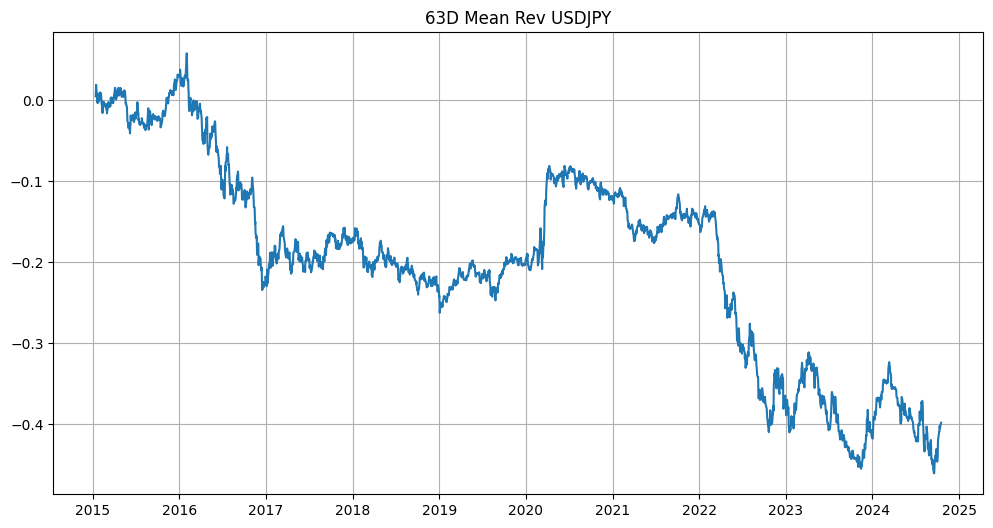

In [87]:
strategy_returns = (ret_s * signal_mr.shift(1)).dropna()
strategy_returns.cumsum().plot(figsize=(12,6), grid=True, title="63D Mean Rev USDJPY")

# Task 4

**Problem:** Combine USDJPY momentum and SP500 buy and hold strategies into one portfolio, with equal / reasonably close weights.

*Piotr comment*: The key is the weighting. You achieve that by making sure that on average they have returns of simmilar scale. This is the difficult part of the interview that only people with real Quant Researcher experience usually get to. 

You do this by **Vol Weighting**, meaning that you give higher weight to strategy with lower volatility and lower weight to strategy with higher volatility, so that on average they will contribute simmilar $ to your daily PnL. 

In [93]:
ret_sp = px_sp_s.pct_change() # SP500 buy and hold (ret * 1)
jpy_mom_returns = (ret_jpy_s * signal_mom.shift(1)).dropna()

In [114]:
# Weighted
ret_sp_weighted = (ret_sp / (ret_sp.rolling(63).std() * 100))
jpy_mom_weighted = (jpy_mom_returns / (jpy_mom_returns.rolling(63).std() * 100))

## Comparison

<AxesSubplot: title={'center': 'No Vol Scaling'}>

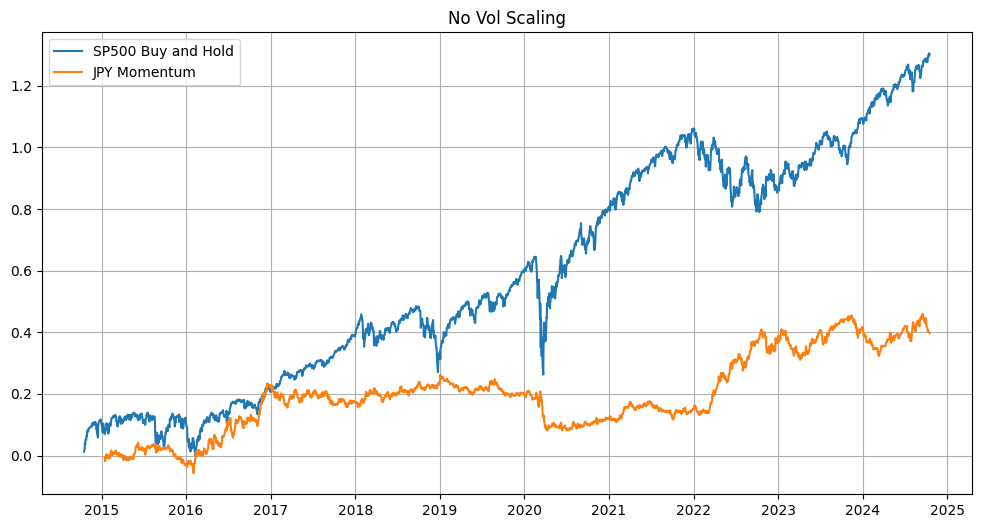

In [108]:
# Without vol scaling - note how USDJPY momentum strategy contributes much less to daily PnL (both on up and down days)
ret_sp.cumsum().plot(figsize=(12,6), title="No Vol Scaling", label="SP500 Buy and Hold", legend=True)
jpy_mom_returns.cumsum().plot(label="JPY Momentum", legend=True, grid=True)

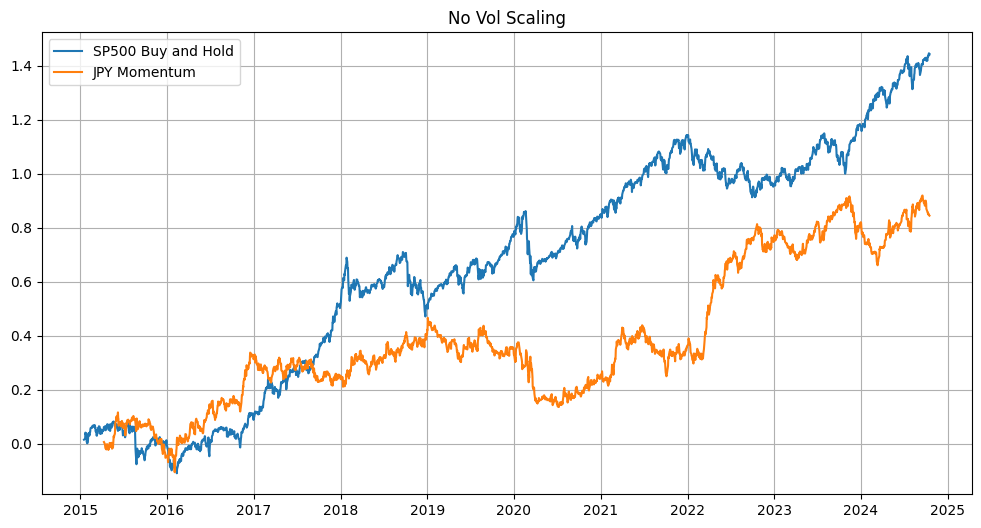

In [116]:
# With vol scaling
ret_sp_weighted.cumsum().plot(figsize=(12,6), title="No Vol Scaling", label="SP500 Buy and Hold", legend=True)
jpy_mom_weighted.cumsum().plot(label="JPY Momentum", legend=True, grid=True);

**Conclusion**

By dividing returns by rolling std I am adjusting for the fact that USDJPY has much lower volatility. Hence both strategies contribute more or less the same to the portfolio in risk terms. SP500 is still much better strategy but what can you do if Jerome Powell goes brrr....